<a href="https://colab.research.google.com/github/DeepOde/tones2tunes/blob/main/models/Model_BI_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt

In [2]:
class Tones2Tunes(nn.Module):
  def __init__(self,unique_notes,dropout=0.3,output_emb=100,rnn_unit=128, dense_unit=64):
    super().__init__()
    # this indicates the vocabulary(unique notes in the whole input)
    self.num_embeddings=unique_notes+1
    # this indicates the vector representation size for each note
    self.embedding_dim=output_emb
    # No of hidden layers in GRU
    self.hidden_unit=rnn_unit
    # creating embedding layer
    self.embedding=nn.Embedding(self.num_embeddings, self.embedding_dim)
    # creating bidirectional GRU
    # by default pytorch returns all the hidden state repre's
    # for more read this [@ https://discuss.pytorch.org/t/pytorch-equivalent-to-keras-layers-lstm-return-sequences-false/53976/2]
    self.BiGRU1=nn.GRU(self.embedding_dim,self.hidden_unit,bidirectional=True,batch_first=True)
    # have to implement self attention(Have to check)

    # adding dropout
    self.dropout1 = nn.Dropout(dropout)
    # adding BIGRU
    self.BiGRU2=nn.GRU(self.hidden_unit,self.hidden_unit,bidirectional=True,batch_first=True)
    # adding dropout
    self.dropout2 = nn.Dropout(dropout)
    # adding fully connected layer
    self.fc = nn.Linear(self.hidden_unit, unique_notes+1)
    self.softmax = nn.Softmax(dim=-1)
  def forward(self,x):
    x=self.embedding(x)
    # print(x.shape)
    output, ht=self.BiGRU1(x)
    # print(output.shape,ht.shape)
    output=output[:,:,:128]+output[:,:,128:]
    output=self.dropout1(output)
    output,ht =self.BiGRU2(output)
    # print(output.shape,ht.shape)
    output=ht[-1]
    output=self.dropout2(output)
    output=self.fc(output)
    output=self.softmax(output)
    return output   
    

In [3]:
def accuracy(yhat,Y_train):
  pred=torch.argmax(yhat,dim=1)
  return (pred==Y_train).float().mean()

In [4]:
losses=[]
acc=[]
def fit(model,opt,X_train,Y_train,epochs=1000):
  for i in range(epochs):
    # have to send batches here
    yhat=model(X_train)
    loss=F.cross_entropy(yhat,Y_train)
    loss.backward()
    losses.append(loss)
    ac=accuracy(yhat,Y_train)
    acc.append(ac)
    opt.step()
    opt.zero_grad()
    if(i%100==0):
      print("Iteration : ",i)
      print("Loss : "+str(loss.item()))
      print("Accuarcy : "+str(ac.item()))
  plt.plot(losses,'r')
  plt.plot(acc,'b')

In [5]:
def predict(X_test):
  return torch.argmax(model(X_test),dim=-1)

In [ ]:
# Testing the model with dummy data

In [6]:
X_train=torch.randint(0,100,(100,100))
Y_train=torch.randint(0,100,(100,1))
Y_train=Y_train.reshape(-1)

tensor([[ 3, 27],
        [27, 88]])

In [ ]:
X_train,Y_train= map(torch.tensor,(X_train,Y_train))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


No CUDA
Iteration :  0
Loss : 4.6149983406066895
Accuarcy : 0.009999999776482582
Iteration :  100
Loss : 4.615055561065674
Accuarcy : 0.0
Iteration :  200
Loss : 4.6148457527160645
Accuarcy : 0.0
Iteration :  300
Loss : 4.614959239959717
Accuarcy : 0.0
Iteration :  400
Loss : 4.614901065826416
Accuarcy : 0.009999999776482582
Iteration :  500
Loss : 4.615035533905029
Accuarcy : 0.0
Iteration :  600
Loss : 4.615030765533447
Accuarcy : 0.009999999776482582
Iteration :  700
Loss : 4.614929676055908
Accuarcy : 0.0
Iteration :  800
Loss : 4.614953517913818
Accuarcy : 0.009999999776482582
Iteration :  900
Loss : 4.614923000335693
Accuarcy : 0.0


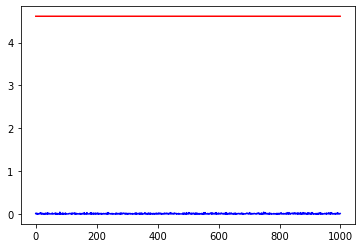

In [ ]:
# Hyperparameters
lr=0.01
epochs=1000

# creating CUDA device
if(torch.cuda.device_count()>0):
  dev="cuda"
  print("CUDA available")
else:
  dev="cpu"
  print("No CUDA")
device=torch.device(dev)
X_train=X_train.to(device)
Y_train=Y_train.to(device)

# Creating an object of the model
model=Tones2Tunes(100)

# Moving the model to GPU
model.to(device)

# Creating the optimizer
opt=optim.SGD(model.parameters(),lr=lr)

# Training the model
fit(model,opt,X_train,Y_train,epochs)

In [ ]:
# Prediction 
y_pred=predict(X_train)
accuracy(model(X_train),Y_train)

tensor(0.)